# imports

In [14]:
import astropy as ap
from stingray import Lightcurve, CrossCorrelation
from dateutil import parser

In [4]:
%run read_matlab_file.ipynb
%run LC_calibration.ipynb

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
safety_time.ipynb loaded successfully!
LC_calibration loaded successfully!


# XPEC data preperation

### TODO
    Stingray seems to be a good API for creating EventList object and writing that to a FITS file


### Notes
    -Assuming 
    -bins_keV are the right most edges! 
    -Anders have filtered for keV >=500 
    -Implementation is ok. Proceed to wrapping a function around it.
    --> have a shift variable as input (have to do with lining up the LC from the different spacecrafts)
    
    
### Problems

    

# ToF

In [5]:
#time of flight from KW to ASIM. Given in seconds
ToF = {"GRB180720":-4.2377,"GRB181222":2.8716, "GRB190206":4.9225, "GRB190305":3.4460,
      "GRB190606":4.0316,"GRB200415":4.1840,"GRB200521":-0.6226,"GRB200716":3.0155,
      "GRB201227":0.7142, "GRB210424":-0.5033, "GRB210619":-2.6183}

In [6]:
def ToF_correction(grb_id=None):
    ToF_us = ToF[grb_id]*1e6
    df,T0 = complete_df(grb_id=grb_id)
    df["tus"], T0_calibrated = df["tus"] - ToF_us, T0 - timedelta(microseconds=ToF_us) #calibrating 
    return df,T0,T0_calibrated

# bin control

In [7]:
df_bin = pd.read_csv(bin_edges_path + "HED_binedges.txt")
df_bin.head()

,energy_bin_start_keV,energy_bin_stop_keV
0,10.00000,12.58925
1,12.58925,15.84893
2,15.84893,19.95262
3,19.95262,25.11886
4,25.11886,31.62278


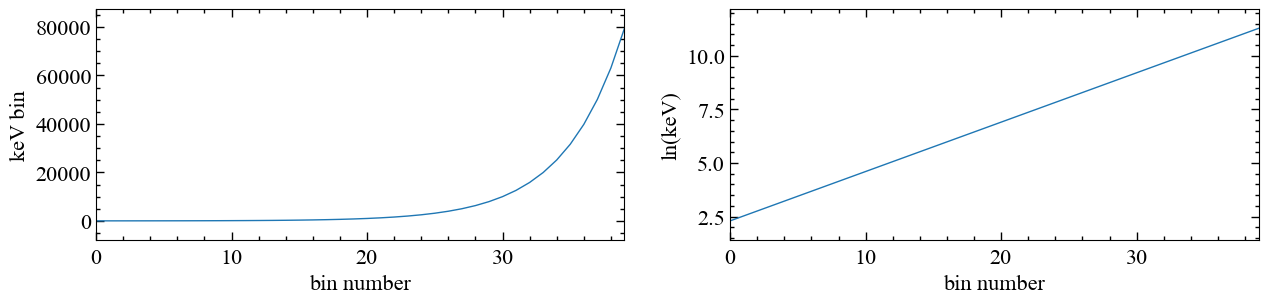

In [8]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,3))

ax1.plot((df_bin["energy_bin_start_keV"]))
ax2.plot(np.log(df_bin["energy_bin_start_keV"]))
ax1.set_xlabel("bin number")
ax1.set_ylabel("keV bin")
ax2.set_xlabel("bin number")
ax2.set_ylabel("ln(keV)")
plt.show()

In [7]:
start = df_bin["energy_bin_start_keV"].to_numpy()
#start = np.append(0,start)
end = df_bin["energy_bin_stop_keV"].to_numpy()
bins_keV=np.append(start,end[-1])
print(len(bins_keV))
bins_keV

41


array([1.000000e+01, 1.258925e+01, 1.584893e+01, 1.995262e+01,
       2.511886e+01, 3.162278e+01, 3.981072e+01, 5.011872e+01,
       6.309573e+01, 7.943282e+01, 1.000000e+02, 1.258925e+02,
       1.584893e+02, 1.995262e+02, 2.511886e+02, 3.162278e+02,
       3.981072e+02, 5.011872e+02, 6.309573e+02, 7.943282e+02,
       1.000000e+03, 1.258925e+03, 1.584893e+03, 1.995262e+03,
       2.511886e+03, 3.162278e+03, 3.981072e+03, 5.011872e+03,
       6.309573e+03, 7.943282e+03, 1.000000e+04, 1.258925e+04,
       1.584893e+04, 1.995262e+04, 2.511886e+04, 3.162278e+04,
       3.981072e+04, 5.011872e+04, 6.309573e+04, 7.943282e+04,
       1.000000e+05])

In [8]:
df_hist_check = pd.read_csv(bin_edges_path + "HED_(0.8 ms to 3.2 ms).txt")
print("Num hist counts totoal: ", sum(df_hist_check["counts"].to_numpy()[1:]))
print("bins_keV are the right most edge")

df_hist_check.tail()

Num hist counts totoal:  300.0
bins_keV are the right most edge


,bins_keV,counts,poisson_error_counts,duration_seconds
36,39810.72,1.0,1.0,0.0024
37,50118.72,0.0,0.0,0.0024
38,63095.73,0.0,0.0,0.0024
39,79432.82,0.0,0.0,0.0024
40,100000.00,0.0,0.0,0.0024


# keV bin function

In [9]:
def keV_hist(df=None,t_start=None,time_interval=None,duration=None,keV_interval=None,keV_bins=None):
    '''
    NOTE: working with ms resolution for the tus array
    
    input: df <pd.dataframe> complete dataframe with no flagged events
    time_interval <tuple> start and end (ms) of the time interval for the keV binning.
    keV_interval <tuple> default is None. Meaning the whole spectrum
    duration <float> defaul is None. Must be provided in ms 
    
    return: <pd.dataframe> with the bin_counts and bin_edges as a dataframe
    '''
    df.sort_values(by=['tus'],inplace=True) #first sorting by tus in increasing order
    
    
    #tus handling-------------------------------------------
    tus_arr = df["tus"].to_numpy()
    tus_arr = tus_arr/1e3 #converting to ms resolution

    
    #if t_start==None:
    #    tus_start,tus_end = min(tus_arr),max(tus_arr)
    #    idx_start, idx_end = find_nearest(tus_arr,tus_start), find_nearest(tus_arr,tus_end)+1 #including the last trigger
    if time_interval != None:
        idx_start, idx_end = find_nearest(tus_arr,time_interval[0]), find_nearest(tus_arr,time_interval[1])+1
    else:
        if duration==None:
            return print("duration must be specified in ms")
        else:
            tus_start,tus_end = t_start,t_start+duration #selecting the interval
            idx_start, idx_end = find_nearest(tus_arr,tus_start), find_nearest(tus_arr,tus_end)+1 #including the nearest trigger
    

    tus_arr = tus_arr[idx_start:idx_end] #selecting the interval for tus
    
    #keV handling-------------------------------------------
    keV_arr = df["keV"].to_numpy()
    keV_arr = keV_arr[idx_start:idx_end] #selecting keV's on the given tus interval
    
    if keV_interval==None:
         keV_lower,keV_upper = 0,1e5 #selecting artificially high bounds
    else: 
        keV_lower,keV_upper = keV_interval[0],keV_interval[1] #selecting the bounds for the keV's

    ii = []
    for i,keV in enumerate(keV_arr): #finding
        if keV_lower<=keV<=keV_upper:
            ii.append(i)
            
    tus_keV_bound = tus_arr[ii]
    keV_bound = keV_arr[ii]
    
    #histogramming-----------------------------------------
    hist_keV,edges_keV = np.histogram(keV_bound,bins=keV_bins)
    
    poisson_arr = np.sqrt(hist_keV) #handle this one. might be some negative numbers in it?
    if hist_keV[0] == 0:
        hist_keV = np.append(-9999.0,hist_keV)
        poisson_arr = np.append(-9999.0,poisson_arr)
    duration_arr = np.append(-9999.0,(([duration/1e3])*(len(hist_keV)-1)))
    df_keV = pd.DataFrame({"bins_keV":edges_keV, "counts":hist_keV, 
                           "poisson_error_counts":poisson_arr, "duration_seconds":duration_arr}) #ERROR different lengths!
    print("Energies binned!")
    return df_keV

# Exporting all keV histograms

In [ ]:
df,T0 = complete_df(grb_id="GRB190206",remove_flag=True)

tus = df["tus"].to_numpy()
start,end = find_nearest(tus/1e3,297),find_nearest(tus/1e3,361)

In [ ]:
start_bg,end_bg = find_nearest(tus/1e3,-500),find_nearest(tus/1e3,200)
start_bg,end_bg

In [ ]:
pd.set_option('display.float_format', '{:.6E}'.format)

In [ ]:
df_keV = keV_hist(df=df,time_interval=(297.0,361.0),keV_bins=bins_keV,duration=64.0)

In [ ]:
df_keV_bg = keV_hist(df=df,time_interval=(-600.0,200.0),keV_bins=bins_keV,duration=64.0)

np.savetxt(r'/Users/andreas/phys/master/GRB/spectral_analysis/GRB190206A_keV_histogram.txt"',df_keV.values, delimiter=',', 
           header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')

np.savetxt(r'/Users/andreas/phys/master/GRB/spectral_analysis/GRB190206A_keV_hist_background (-600 ms to 200 ms).txt"',df_keV_bg.values, delimiter=',', 
           header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')

## bring KW data into ASIM referance frame with ToF and time lagg=27 ms

### TODO: 
    -Round cal_abc to .7 position
    -Subtract/add ToF from the bins
    -subtract/add time lagg to kw data
    -plot the histograms together for the selected time interval

    -Prepare the new data file for GRB201227


In [11]:
kw_grb190206_2ms = kw_lc_path + "GRB190206A_2ms.txt"
kw_df = pd.read_csv(kw_grb190206_2ms,sep='\s+')

G1,G2,G3 = kw_df["G1"], kw_df["G2"], kw_df["G3"]

kw_bin_left = kw_df["Ti"].to_numpy()#+ToF["GRB190206"]
kw_bin_right = kw_df["Tf"].to_numpy()#+ToF["GRB190206"]

kw_bin_left = np.append(kw_bin_left,kw_bin_right[-1])


kw_start = find_nearest(kw_bin_left,0)
kw_end = find_nearest(kw_bin_left,0)+ int(64/2) #64ms interval

kw_bin_left = kw_bin_left[kw_start:kw_end]
G1,G2,G3 = G1[kw_start:kw_end],G2[kw_start:kw_end],G3[kw_start:kw_end]


binwidth=np.append(np.round(np.diff(kw_bin_left),3),0.002) #binwidths differentiated and rounded. Added the last bin width
len(G1),len(kw_bin_left),len(binwidth)

(32, 32, 32)

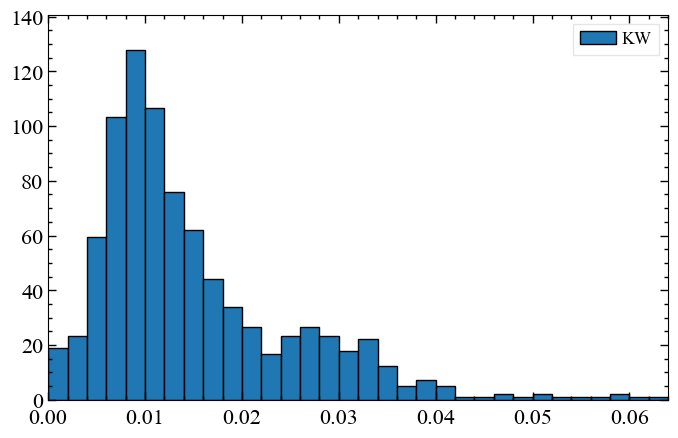

In [12]:
plt.bar(x=kw_bin_left,height=G3,width=binwidth,align="edge",edgecolor="black",label="KW")
plt.legend()
plt.show()

### ASIM

In [ ]:
df,T0 = complete_df(grb_id="GRB190206",remove_flag=True)
df.sort_values(by=['tus'],inplace=True)
tus = df["tus"].to_numpy()
tus = tus/1e3
opt_cut_asim = 293
A_start,A_end = find_nearest(tus,opt_cut_asim),find_nearest(tus,opt_cut_asim+64)
tus_cut = tus[A_start:A_end]
print(T0)
A_hist,A_edges = np.histogram(tus_cut,bins=np.arange(min(tus_cut), max(tus_cut) + 2, 2))

In [ ]:
plt.bar(x=np.arange(0,len(kw_bin_left)),height=(G3+G2),width=1,align="edge",edgecolor="black",label="KW G3 + G2",alpha=0.7)
#plt.bar(x=np.arange(0,len(kw_bin_left)),height=G2,width=1,align="edge",edgecolor="black",label="KW G2",alpha=0.3)
#plt.bar(x=np.arange(0,len(kw_bin_left)),height=G1,width=1,align="edge",edgecolor="black",label="KW G1",alpha=0.2)

plt.bar(x=np.arange(0,len(A_edges)-1), height=A_hist,width=1,align="edge",edgecolor="black",label="ASIM",alpha=0.5)
plt.xlabel("bin number [64 ms window, 2ms bins]")
plt.ylabel("counts/ 2ms")
plt.legend()
plt.title("KW plotted from T0_KW and ASIM plotted from T0_ASIM + {}ms".format(opt_cut_asim))
plt.show()

In [ ]:
df,T0 = complete_df(grb_id="GRB190206",remove_flag=True)
df.head()

In [ ]:
df,T0 = complete_df(grb_id="GRB190206",remove_flag=True)

df.sort_values(by=['tus'],inplace=True)
tus = df["tus"].to_numpy()
plot_HED(tus_arr=tus,binsize=2,T0=T0)

In [ ]:
T0_KW = "03:49:23.926"
T0_KW_dt = datetime.strptime(T0_KW,"%H:%M:%S.%f")
T0_KW_dt + timedelta(seconds=ToF["GRB190206"])
T0_KW_dt

In [ ]:
# export keV histogram for GRB190206A in the same format as example by Anders, Duration is 64 ms 
# lag = -27.


#build spectra for main event on this interval
time_interval = 297,297+64 #ms


#interval for background:
bg_interval = -0.9,-0.2


In [ ]:
#for grb_id in selected_grb_id:
#    df,T0 = complete_df(grb_id=grb_id,remove_flag=True,flag_cut="HED")
#    df_keV = keV_hist(df=df,keV_bins=bins_keV)
#    print("Exporting csv")
#    df_keV.to_csv(path_keV_hist + grb_id,index=False)

In [ ]:
#bins_keV


from astropy.table import Table
df = pd.read_csv("/Users/andreas/phys/master/GRB/spectral_analysis/keV_histograms/GRB180720")
t = Table.from_pandas(df)
t.write('GRB180720_new.fits')

# corrolate_lc function

tus array OK ...


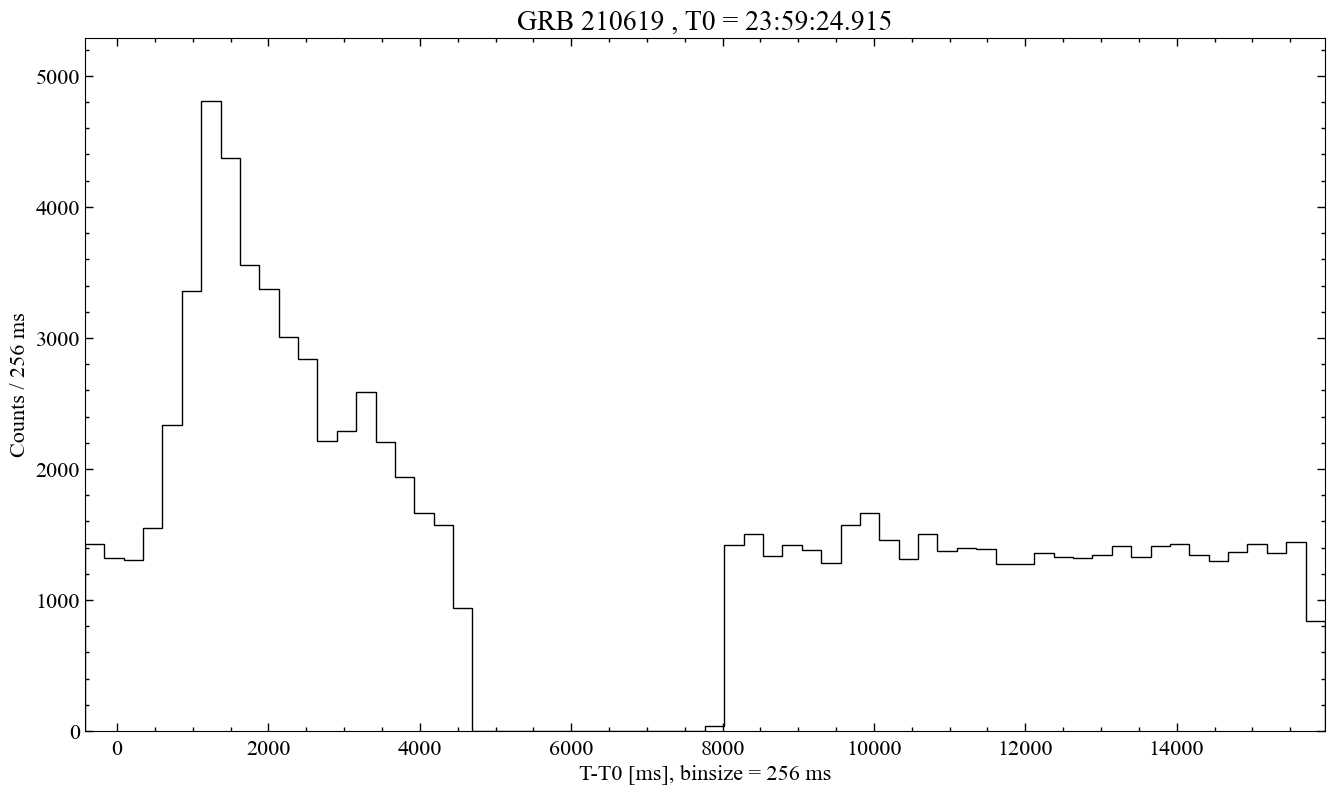

In [59]:
plot_HED(tus_arr=tus,T0=T0_GRB210619,binsize=256)

## ASIM import and preparation

In [10]:
df_ASIM, T0_ASIM = complete_df(grb_id="GRB210619",remove_flag=True)
print(T0_ASIM)
df_ASIM.sort_values(by=["tus"],inplace=True)
df_ASIM.head()

Creating df for long GRB
Absolute time correction subtracted from T0
75 valleys removed
Absolute time correction subtracted from T0
76 valleys removed
Absolute time correction subtracted from T0
59 valleys removed
Absolute time correction subtracted from T0
59 valleys removed
Absolute time correction subtracted from T0
75 valleys removed
Absolute time correction subtracted from T0
65 valleys removed
Absolute time correction subtracted from T0
75 valleys removed
Absolute time correction subtracted from T0
56 valleys removed
Absolute time correction subtracted from T0
49 valleys removed
Absolute time correction subtracted from T0
75 valleys removed
found one cutting index ... 
found one cutting index ... 
found one cutting index ... 
subseq not found in next array ... keeping whole array
found one cutting index ... 
found one cutting index ... 
found one cutting index ... 
found one cutting index ... 
found one cutting index ... 
GRB concatenated ...
erg converted to keV
df sorted by adr

,tus,erg,typ,adr,dau,det,keV,cal_abc,st,dt,flag
0,-425404.361111,34,0,8,3,2,973.063308,"-0.006382, 29.5333, -23.6913",0.946127,NaN,False
1,-425198.194444,67,0,6,2,3,783.196447,"0.004273, 10.7282, 45.22555",3.831964,NaN,False
2,-425090.666667,2037,0,10,4,1,37300.371034,"0.002586, 13.017, 54.4738",32.361187,NaN,False
3,-425090.611111,1571,0,11,4,2,29468.229927,"0.002877, 14.2272, 16.74477",23.000000,NaN,False
4,-425090.583333,1595,0,6,2,3,28027.323375,"0.004273, 10.7282, 45.22555",23.000000,107.611111,False


In [18]:
kw_filename = 'GRB210619B_16ms.txt' 
kw_df = pd.read_csv(kw_lc_path + kw_filename,sep='\s+')

G1,G2,G3 = kw_df["G1"], kw_df["G2"], kw_df["G3"]

kw_bin_left = kw_df["Ti"].to_numpy()#+ToF["GRB190206"]
kw_bin_right = kw_df["Tf"].to_numpy()#+ToF["GRB190206"]


kw_end = find_nearest(kw_bin_left,15)
print(kw_end)

969


In [11]:
tus_A = df_ASIM["tus"].to_numpy()
binsize = 0.016 # 2 ms binsize
kw_filename = 'GRB210619B_16ms.txt' 

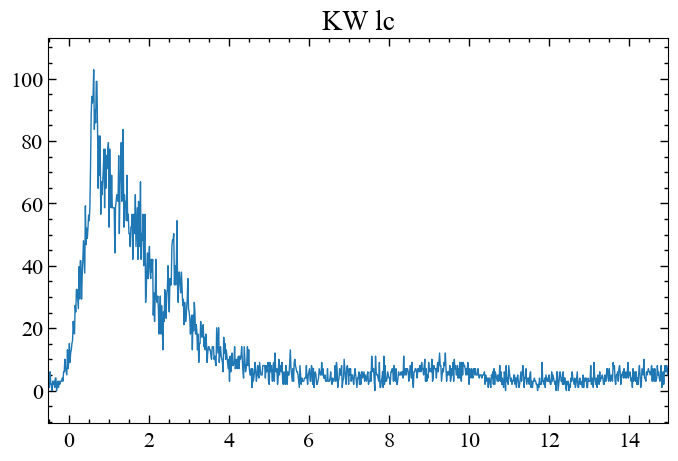

-448000.0


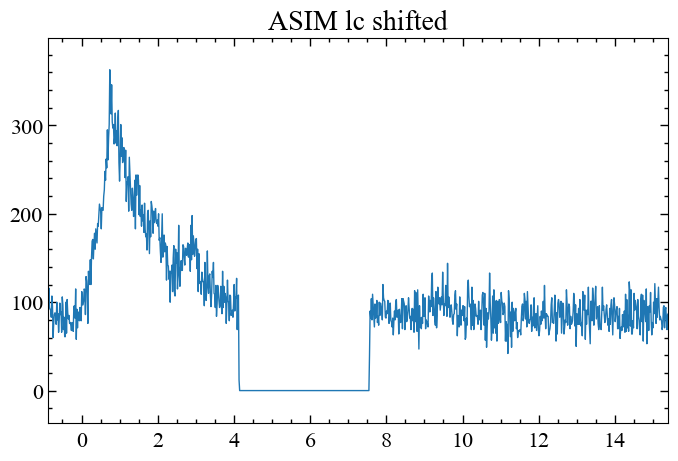

In [22]:
tshift = cross_corrolate(tus_ASIM=tus_A,binsize=binsize,kw_filename=kw_filename)

In [25]:
#notes: KW bins are given in seconds --> Converting tus_ASIM to seconds 

def cross_corrolate(tus_ASIM=None, kw_filename=None, binsize=None):
    """
    cross corrolation function between ASIM and KW. Function will itself bin the photon array and return the desired t_shift lag to shift the data into KW ref frame
    input
    --------------------------------------
    tus_ASIM <np.array>: tus array
    kw_filename <str>: filename. Path is provided
    binsize <float>: given in seconds
    
    return
    --------------------------------------
    t_shift <float>: given in us. Rounded to 6 sig figures """
    
    tus_ASIM = tus_ASIM/1e6 

    hist_ASIM, edges_ASIM = np.histogram(tus_ASIM,bins=np.arange(min(tus_ASIM),max(tus_ASIM)+binsize,binsize))

    kw_file = kw_lc_path + kw_filename

    kw_df = pd.read_csv(kw_file,sep='\s+')

    G3 = kw_df["G3"].to_numpy()

    kw_bin_left = kw_df["Ti"].to_numpy()
    #kw_bin_right = kw_df["Tf"].to_numpy()

    kw_dt = np.round(np.diff(kw_bin_left),3)
    i_stop_kw = np.where(kw_dt>binsize)[0][0]

    #kw_bins = np.append(kw_bin_left,kw_bin_right[-1])


    kw_lc = Lightcurve(time=kw_bin_left[:i_stop_kw],counts=G3[:i_stop_kw],skip_checks=True)
    asim_lc = Lightcurve(time=edges_ASIM[:-1],counts=hist_ASIM,skip_checks=True)

    kw_lc.plot(title="KW lc")
    #asim_lc.plot(title="ASIM lc")

    CC = CrossCorrelation(kw_lc,asim_lc,mode="full")
    #CC.plot(labels = ['Time Lags (seconds)','Correlation'])
    
    t_shift = np.round(CC.cal_timeshift(dt=binsize)[0],6)*1e6
    asim_lc_shifted = asim_lc.shift(CC.time_shift)
    asim_lc_shifted.plot(title="ASIM lc shifted")
    return t_shift

## Extracting the data for GRB210619
    Length of df_GRB210619 is 91,901